![Crisp](img/logo.png)
# On-shelf availability

[![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-orange?logo=google-colab&style=for-the-badge)](https://colab.research.google.com/github/gocrisp/blueprints/blob/main/notebooks/crisp_osa.ipynb)
[![Open in Vertex AI](https://img.shields.io/badge/Open%20in-Vertex%20AI%20Workbench-brightgreen?logo=google-cloud&style=for-the-badge)](https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/gocrisp/blueprints/main/notebooks/crisp_osa.ipynb)
[![Open in Databricks](https://img.shields.io/badge/databricks-red?logo=databricks&style=for-the-badge)](https://www.databricks.com/try-databricks)
[![View on GitHub](https://img.shields.io/badge/View%20on-GitHub-lightgrey?logo=github&style=for-the-badge)](https://github.com/gocrisp/blueprints/blob/main/notebooks/crisp_osa.ipynb)

> To deploy a notebook in Databricks:
> 1. Open your workspace and navigate to the folder where you want to import the notebook.
> 2. Click the triple-dot icon (next to the Share button).
> 3. Select Import and choose URL as the import method.
> 4. Paste the notebook's URL and click Import to complete the process.

This notebook demonstrates how to perform on-shelf availability analysis on sales data to identify patterns and trends over time. On-shelf availability is a measure of how well a retailer is able to keep products in stock and available for purchase. By analyzing sales data, we can identify products that are frequently out of stock and take steps to improve availability. It leverages store clustering to identify patterns in sales data and detect anomalies.

## Set the required environment variables

In [1]:
import os

os.environ["ACCOUNT_ID"] = "80047"
# os.environ["CONNECTOR_ID"] = "7240"
retailer = "home_depot"

### Run Crisp common notebook

This notebook uses the [crisp_common.ipynb](./crisp_common.ipynb) notebook to load the common functions and variables. The `crisp_common.ipynb` notebook contains the common functions and variables that are used across the Crisp notebooks.

In [ ]:
if not os.path.exists("crisp_common.ipynb"):
    print("Downloading crisp_common.ipynb")
    !wget https://raw.githubusercontent.com/gocrisp/blueprints/main/notebooks/crisp_common.ipynb -O crisp_common.ipynb
else:
    print("crisp_common.ipynb already exists")

%run crisp_common.ipynb

In [3]:
dim_product = "exp_harmonized_retailer_dim_product"
dim_store = "exp_harmonized_retailer_dim_store"
fact_sales = "exp_harmonized_retailer_fact_sales"
fact_inventory = "exp_harmonized_retailer_fact_inventory_store"

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

### Get anchor date

This steps is not necessary if you are running the notebook in production. It is only required for testing purposes, as we don't know what data is available in for us


In [5]:
%%load anchor
WITH candidates AS(
    SELECT MAX(date_key) AS anchor_date FROM `{project}`.`{dataset}`.`{fact_sales}` WHERE retailer = '{retailer}'
    UNION ALL
    SELECT MAX(date_key) AS anchor_date FROM `{project}`.`{dataset}`.`{fact_inventory}` WHERE retailer = '{retailer}'
    UNION ALL
    SELECT CURRENT_DATE() AS anchor_date
)
SELECT MIN(anchor_date) AS anchor_date FROM candidates

,anchor_date
0,2023-11-01


In [6]:
anchor_date = anchor["anchor_date"][0]
start_date = anchor_date - pd.DateOffset(days=90)
end_date = anchor_date
start_date_sql = start_date.strftime("'%Y-%m-%d'")
end_date_sql = end_date.strftime("'%Y-%m-%d'")
print(f"Using data from {start_date_sql} to {end_date_sql}")

Using data from '2023-08-03' to '2023-11-01'


## Load data

We limit the number of stores to just those from Florida to reduce the data size, as this process is computationally intensive. You can remove this filter if you have enough resources to handle the full dataset.

In [7]:
%%load df
WITH limited_stores AS(
SELECT
  store_id,
FROM
  `{project}`.`{dataset}`.`{dim_store}`
WHERE
  store_state IN ('FL')
),
fact_sales AS(
SELECT
  date_key,
  store_id,
  product_id,
  SUM(sales_quantity) AS sales_quantity
FROM
  `{project}`.`{dataset}`.`{fact_sales}`
INNER JOIN limited_stores USING(store_id)
WHERE
  retailer = '{retailer}'
  AND date_key BETWEEN {start_date_sql} AND {end_date_sql}
GROUP BY
    1, 2, 3
),
fact_inventory AS(
SELECT
  date_key,
  store_id,
  product_id,
  SUM(on_hand_quantity) AS on_hand_quantity
FROM
  `{project}`.`{dataset}`.`{fact_inventory}`
INNER JOIN limited_stores USING(store_id)
WHERE
  retailer = '{retailer}'
  AND date_key BETWEEN {start_date_sql} AND {end_date_sql}
GROUP BY
  1, 2, 3
)
SELECT
  date_key,
  product_id,
  store_id,
  sales_quantity,
  on_hand_quantity
FROM
  fact_sales
FULL JOIN
  fact_inventory
USING
  (date_key, product_id, store_id)

,date_key,product_id,store_id,sales_quantity,on_hand_quantity
0,2023-08-25,6663967147089049423,7929021731978788628,0E-9,None
1,2023-10-02,4674518448395031514,5860763806770610570,0E-9,None
2,2023-08-11,5236192933527231179,4503811537647222503,0E-9,None
3,2023-08-26,7507250286268732142,71347627970057411,0E-9,None
4,2023-10-06,4688659903155947852,1480851996928824367,1.000000000,None
...,...,...,...,...,...
890322,2023-10-18,6079073340849927156,2318024415169056923,None,6.000000000
890323,2023-10-02,6079073340849927156,7159068990848394410,None,11.000000000
890324,2023-08-13,6079073340849927156,2623424223170782079,None,2.000000000
890325,2023-08-27,6079073340849927156,4901131030125847190,None,1.000000000


In [8]:
df[["sales_quantity", "on_hand_quantity"]] = df[
    ["sales_quantity", "on_hand_quantity"]
].fillna(0.0)
df

,date_key,product_id,store_id,sales_quantity,on_hand_quantity
0,2023-08-25,6663967147089049423,7929021731978788628,0E-9,0.0
1,2023-10-02,4674518448395031514,5860763806770610570,0E-9,0.0
2,2023-08-11,5236192933527231179,4503811537647222503,0E-9,0.0
3,2023-08-26,7507250286268732142,71347627970057411,0E-9,0.0
4,2023-10-06,4688659903155947852,1480851996928824367,1.000000000,0.0
...,...,...,...,...,...
890322,2023-10-18,6079073340849927156,2318024415169056923,0.0,6.000000000
890323,2023-10-02,6079073340849927156,7159068990848394410,0.0,11.000000000
890324,2023-08-13,6079073340849927156,2623424223170782079,0.0,2.000000000
890325,2023-08-27,6079073340849927156,4901131030125847190,0.0,1.000000000


## Load store clusters

We will load the store clusters generated from the [store clustering notebook](https://github.com/gocrisp/blueprints/blob/main/notebooks/crisp_store_clustering.ipynb). If not available, you can mark all stores as a single cluster.

In [9]:
if os.path.exists("store_clusters.csv"):
    dim_store_clusters = pd.read_csv("store_clusters.csv")
    dim_store_clusters.value_counts("Cluster")
else:
    dim_store_clusters = pd.DataFrame(
        {"store_id": df["store_id"].unique(), "Cluster": 0}
    )
dim_store_clusters.value_counts("Cluster")

Cluster
0    3039
3    2964
1    2932
2    2893
Name: count, dtype: int64

# Visualize day over day sales and on-hand quantity sums across all stores and products

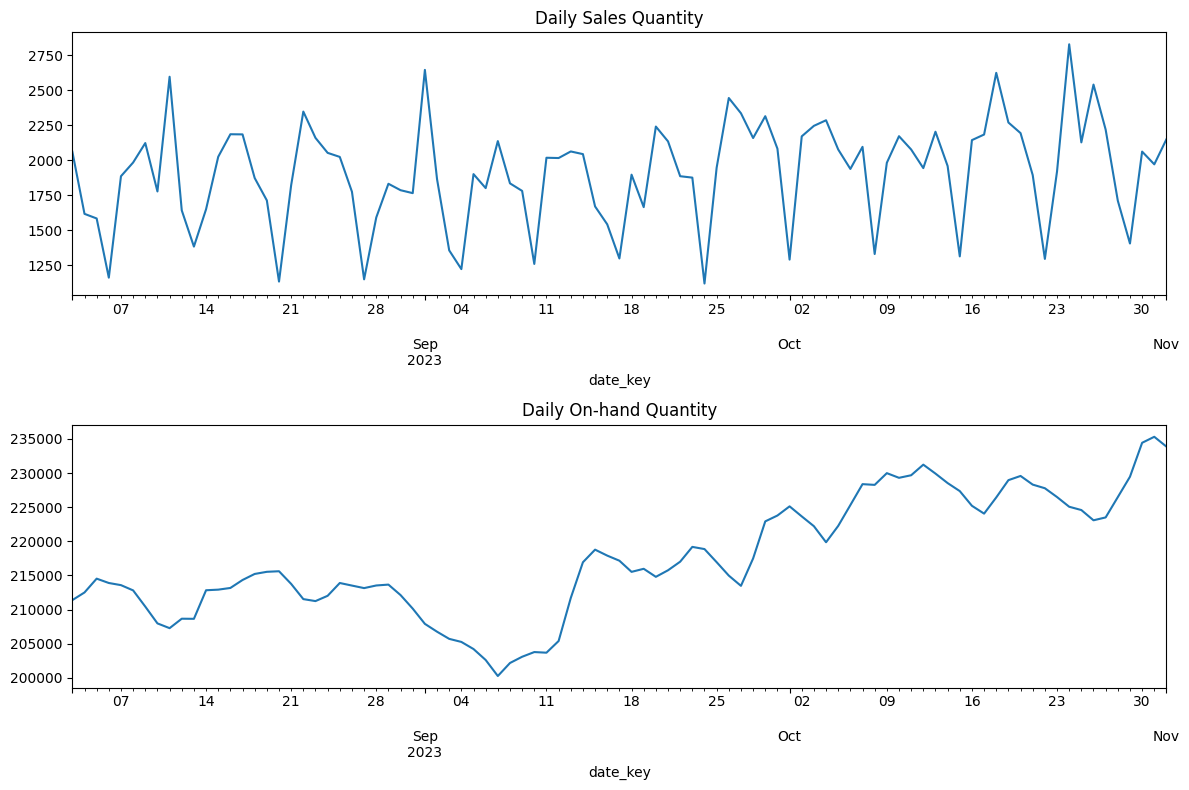

In [10]:
df["date_key"] = pd.to_datetime(df["date_key"])
df["sales_quantity"] = df["sales_quantity"].astype(float)
df["on_hand_quantity"] = df["on_hand_quantity"].astype(float)

daily_sales = df.groupby("date_key")["sales_quantity"].sum()
daily_on_hand = df.groupby("date_key")["on_hand_quantity"].sum()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
daily_sales.plot(ax=axes[0], title="Daily Sales Quantity")
daily_on_hand.plot(ax=axes[1], title="Daily On-hand Quantity")
plt.tight_layout()
plt.show()

## Caclulate expected velocity

Expected velocity is the average sales velocity of a product across all stores in the same cluster, excluding the store in question. This metric helps identify stores that are underperforming compared to other stores in the same cluster.

In [11]:
# 1. Convert all numeric columns that might be in Decimal to float to avoid type errors
df["sales_quantity"] = df["sales_quantity"].astype(float)
df["on_hand_quantity"] = df["on_hand_quantity"].astype(float)

# 2. Identify product-store pairs that have ever recorded a nonzero sale and sold at least 20 units in total
ever_sold = df.groupby(["product_id", "store_id"], as_index=False)[
    "sales_quantity"
].sum()
ever_sold_stores = ever_sold[ever_sold["sales_quantity"] > 10][
    ["product_id", "store_id"]
]


# 3. Filter df to only include product-store pairs that have sold at least once
df_filtered = df.merge(ever_sold_stores, on=["product_id", "store_id"], how="inner")

# 4. Merge with store cluster info
df_merged = df_filtered.merge(dim_store_clusters, on="store_id", how="left")

# 5. Compute velocity (ignore rows with zero on_hand by making them NaN)
df_merged["velocity"] = np.where(
    df_merged["on_hand_quantity"] <= 0, np.nan, df_merged["sales_quantity"]
).astype(float)

# 6. Compute cluster-level stats for velocity
cluster_stats = df_merged.groupby(
    ["date_key", "product_id", "Cluster"], as_index=False
).agg(sum_velocity=("velocity", "sum"), count_velocity=("velocity", "count"))

# 7. Merge cluster stats back into df_merged
df_merged = df_merged.merge(
    cluster_stats, on=["date_key", "product_id", "Cluster"], how="left"
)

# 8. Calculate expected velocity: (sum_velocity - velocity of store) / (count_velocity - 1)
mask = df_merged["count_velocity"] > 1
df_merged.loc[mask, "expected_velocity"] = (
    df_merged.loc[mask, "sum_velocity"] - df_merged.loc[mask, "velocity"]
) / (df_merged.loc[mask, "count_velocity"] - 1)
df_merged.loc[~mask, "expected_velocity"] = np.nan

# 9. Fill NaN in expected_velocity with 0.0 if desired
df_merged["expected_velocity"] = df_merged["expected_velocity"].fillna(0.0)

# 10. Create the final prepared_df
prepared_df = df_merged[
    [
        "date_key",
        "product_id",
        "store_id",
        "sales_quantity",
        "on_hand_quantity",
        "expected_velocity",
    ]
]

prepared_df

,date_key,product_id,store_id,sales_quantity,on_hand_quantity,expected_velocity
0,2023-10-06,4688659903155947852,1480851996928824367,1.0,0.0,0.000000
1,2023-10-31,4688659903155947852,1298212123947448995,15.0,0.0,0.000000
2,2023-10-24,4698241861611557158,4643817461641511594,1.0,0.0,0.000000
3,2023-08-16,4688659903155947852,9055903599926765620,0.0,0.0,0.000000
4,2023-10-21,7558062471067821530,2128021299097599986,3.0,0.0,0.000000
...,...,...,...,...,...,...
238652,2023-08-23,6079073340849927156,5014600336290109948,0.0,3.0,0.000000
238653,2023-09-10,6079073340849927156,4830511402327721254,0.0,15.0,0.000000
238654,2023-08-03,6079073340849927156,860507281421602245,0.0,0.0,0.000000
238655,2023-08-26,6079073340849927156,9055903599926765620,0.0,20.0,-0.428571


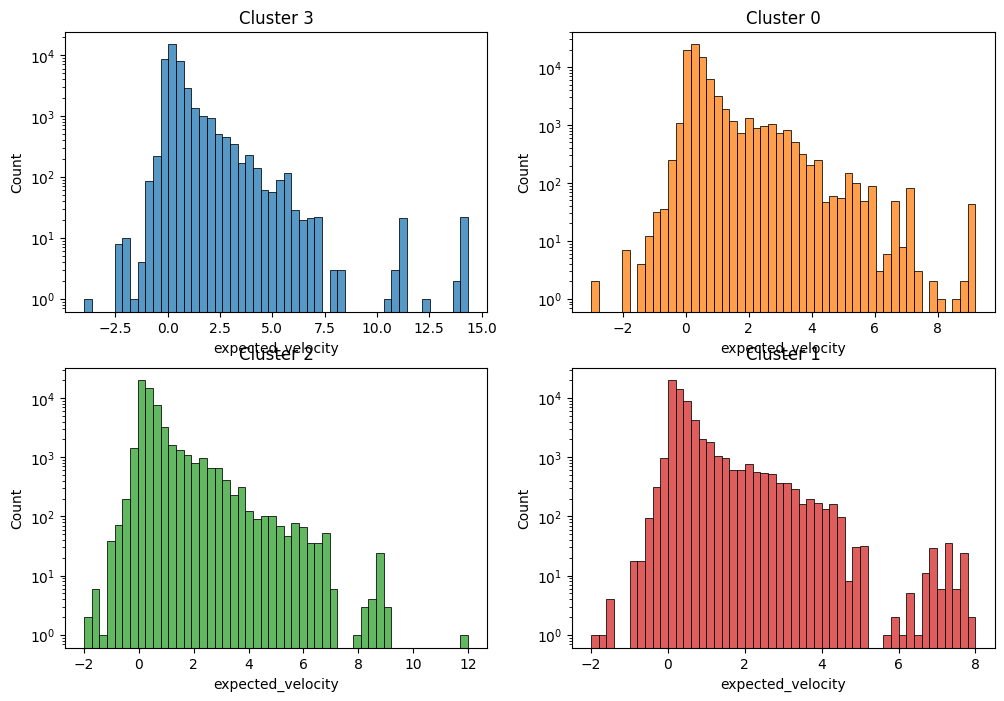

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
clusters = df_merged["Cluster"].unique()
for i, cluster in enumerate(clusters):
    ax = axes[i // 2, i % 2]
    sns.histplot(
        df_merged[df_merged["Cluster"] == cluster]["expected_velocity"],
        ax=ax,
        color=f"C{i}",
        bins=50,
    )
    ax.set_title(f"Cluster {cluster}")
    ax.set_yscale("log")

## Let's analyze the data

In [19]:
prepared_df = prepared_df.sort_values(by=["product_id", "store_id", "date_key"])


def calculate_stats(group):
    # We'll start from the last day and move backwards to find inactivity
    inactivity_count = 0
    inactivity_indices = []

    for i in reversed(range(len(group))):
        row = group.iloc[i]
        if (row["sales_quantity"] == 0) and (row["on_hand_quantity"] > 0):
            inactivity_count += 1
            inactivity_indices.append(i)
        else:
            # Break once condition no longer holds
            break

    total_inactivity_expected_velocity = 0.0
    prob = 1.0
    resistance_line = np.nan
    resistance_line_hits = 0
    resistance_line_expected_velocity = 0.0
    resistance_line_expected_sales_probability = np.nan

    if inactivity_count > 0:
        # Extract streak data
        streak_data = group.iloc[inactivity_indices]
        streak_velocities = streak_data["expected_velocity"]
        total_inactivity_expected_velocity = streak_velocities.sum()

        # Probability of zero sales for entire streak (all days) under Poisson
        # Zero-sales probability on a single day: exp(-λ)
        # For multiple days, multiply probabilities together
        prob = np.exp(-streak_velocities).prod()

    # Determine resistance line = minimal positive on-hand quantity in the streak
    positive_on_hand = group["on_hand_quantity"][group["on_hand_quantity"] > 0]

    if len(positive_on_hand) > 0:
        resistance_line = positive_on_hand.min()
        not_hit = True
        resistance_line_hits = 0
        for i in range(len(group)):
            if group.iloc[i]["sales_quantity"] <= 0:
                if group.iloc[i]["on_hand_quantity"] == resistance_line and not_hit:
                    not_hit = False
                    resistance_line_hits += 1
                elif group.iloc[i]["on_hand_quantity"] > resistance_line:
                    not_hit = True
        resistence_line_velocities = group["expected_velocity"][
            group["on_hand_quantity"] == resistance_line
        ]
        resistance_line_expected_velocity = resistence_line_velocities.sum()
        if len(resistence_line_velocities) > 0:
            resistance_line_expected_sales_probability = np.exp(
                -resistence_line_velocities
            ).prod()

    # Last on-hand quantity from the last record
    last_on_hand = group.iloc[-1]["on_hand_quantity"]
    # Total sales days
    total_sales_days = (group["sales_quantity"] > 0).sum()

    return pd.Series(
        {
            "current_inactivity": inactivity_count,
            "last_on_hand_quantity": last_on_hand,
            "total_sales_days": total_sales_days,
            "expected_velocity": total_inactivity_expected_velocity,
            "probability_inactivity_poisson": prob,
            "resistance_line": resistance_line,
            "resistance_line_hits": resistance_line_hits,
            "resistance_line_expected_velocity": resistance_line_expected_velocity,
            "resistance_line_expected_sales_probability": resistance_line_expected_sales_probability,
        }
    )


result = (
    prepared_df.groupby(["product_id", "store_id"])
    .apply(lambda g: calculate_stats(g))
    .reset_index()
)

result

/var/folders/yc/tk8l4tpj03s23nsy68jphwxr0000gn/T/ipykernel_59179/3323054326.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: calculate_stats(g))


,product_id,store_id,current_inactivity,last_on_hand_quantity,total_sales_days,expected_velocity,probability_inactivity_poisson,resistance_line,resistance_line_hits,resistance_line_expected_velocity,resistance_line_expected_sales_probability
0,13100840677028524,1480851996928824367,0.0,0.0,1.0,0.000000,1.000000,NaN,0.0,0.000000,NaN
1,122967938238698056,199402249302644433,13.0,35.0,21.0,4.090909,0.016724,1.0,1.0,1.000000,0.367879
2,122967938238698056,320797105063219894,3.0,18.0,4.0,0.857143,0.424373,12.0,1.0,4.571429,0.010343
3,122967938238698056,475950955165590002,6.0,25.0,18.0,0.818182,0.441233,4.0,1.0,1.636364,0.194687
4,122967938238698056,1101273224051657847,5.0,12.0,7.0,1.500000,0.223130,1.0,1.0,0.125000,0.882497
...,...,...,...,...,...,...,...,...,...,...,...
2737,9049183011065399697,9055903599926765620,0.0,399.0,68.0,0.000000,1.000000,264.0,0.0,2.388889,0.091732
2738,9049183011065399697,9109516862512306082,0.0,110.0,41.0,0.000000,1.000000,47.0,0.0,2.490566,0.082863
2739,9049183011065399697,9125856341774185011,0.0,593.0,79.0,0.000000,1.000000,334.0,0.0,1.083333,0.338465
2740,9049183011065399697,9178119398148503681,0.0,102.0,37.0,0.000000,1.000000,87.0,1.0,9.377358,0.000085


In [20]:
result.describe(include="all")

,product_id,store_id,current_inactivity,last_on_hand_quantity,total_sales_days,expected_velocity,probability_inactivity_poisson,resistance_line,resistance_line_hits,resistance_line_expected_velocity,resistance_line_expected_sales_probability
count,2742.0,2742.0,2742.000000,2742.000000,2742.000000,2742.000000,2.742000e+03,2628.000000,2742.000000,2742.000000,2.628000e+03
mean,5281235677204185088.0,4658749735995586560.0,4.353756,63.010212,19.151349,2.047845,5.325976e-01,35.948250,0.768417,2.175255,3.757866e-01
std,2691367022414326784.0,2838054635896087040.0,6.423883,133.187321,14.816156,5.081792,4.772714e-01,80.620389,0.542248,4.211624,3.484111e-01
min,13100840677028524.0,15898023538001700.0,0.000000,0.000000,1.000000,-2.500000,3.547989e-41,1.000000,0.000000,-1.800000,1.414869e-32
25%,3012002127303854592.0,2128021299097600000.0,0.000000,18.000000,10.000000,0.000000,1.053992e-01,7.000000,0.000000,0.433696,7.983624e-02
50%,5465187907353202688.0,4582617186828798976.0,2.000000,31.000000,14.500000,0.666667,5.134171e-01,16.000000,1.000000,1.127016,3.037982e-01
75%,7991324541002599424.0,7030476271459946496.0,6.000000,58.000000,23.000000,2.250000,1.000000e+00,33.000000,1.000000,2.432843,6.065307e-01
max,9049183011065399296.0,9193430749444362240.0,76.000000,2147.000000,88.000000,93.139608,1.218249e+01,1407.000000,4.000000,73.335686,6.049647e+00


### Define your alerting conditions below

In [26]:
alerts = result.copy()
alerts["alert"] = np.where(
    (alerts["resistance_line_hits"] >= 2)
    & (alerts["resistance_line"] >= 1)
    & (alerts["resistance_line_expected_sales_probability"] < 0.1),
    "Phantom Inventory",
    "No Alert",
)
alerts["alert"] = np.where(
    (alerts["current_inactivity"] >= 3)
    & (alerts["probability_inactivity_poisson"] < 0.1)
    & (alerts["last_on_hand_quantity"] > 0),
    "Zero Sales",
    alerts["alert"],
)
alerts = alerts[alerts["alert"] != "No Alert"]
alerts.value_counts("alert")
alerts

,product_id,store_id,current_inactivity,last_on_hand_quantity,total_sales_days,expected_velocity,probability_inactivity_poisson,resistance_line,resistance_line_hits,resistance_line_expected_velocity,resistance_line_expected_sales_probability,alert
1,122967938238698056,199402249302644433,13.0,35.0,21.0,4.090909,1.672402e-02,1.0,1.0,1.000000,3.678794e-01,Zero Sales
8,122967938238698056,1376611106837177352,5.0,31.0,13.0,0.750000,4.723666e-01,30.0,2.0,2.750000,6.392786e-02,Phantom Inventory
12,122967938238698056,2623424223170782079,15.0,16.0,14.0,5.000000,6.737947e-03,4.0,0.0,0.200000,8.187308e-01,Zero Sales
15,122967938238698056,3317201485650318587,15.0,28.0,11.0,3.285714,3.741385e-02,13.0,2.0,1.250000,2.865048e-01,Zero Sales
19,122967938238698056,4463042894972055198,7.0,13.0,9.0,4.285714,1.376379e-02,1.0,1.0,-0.375000,1.454991e+00,Zero Sales
...,...,...,...,...,...,...,...,...,...,...,...,...
2716,9049183011065399697,7929021731978788628,3.0,121.0,44.0,6.052632,2.351665e-03,49.0,0.0,3.108108,4.468542e-02,Zero Sales
2722,9049183011065399697,8202265536595904105,2.0,136.0,42.0,5.555556,3.865920e-03,38.0,2.0,5.916667,2.694166e-03,Phantom Inventory
2725,9049183011065399697,8614395383910467216,20.0,46.0,12.0,52.396226,1.756338e-23,27.0,1.0,33.620279,2.505522e-15,Zero Sales
2728,9049183011065399697,8702065721875310107,7.0,64.0,21.0,15.833333,1.329446e-07,46.0,1.0,5.972222,2.548572e-03,Zero Sales


## Prepare labels for the alert

In [22]:
%%load products_df
SELECT
    product_id,
    brand,
    product
FROM
    `{project}`.`{dataset}`.`{dim_product}`

,product_id,brand,product
0,2701722886168190349,None,None
1,2701291324409010887,None,None
2,4511736065027911885,None,None
3,4674518448395031514,None,None
4,1338335131349416674,None,None
...,...,...,...
10393,4927012588844976201,BRAND NAME 1,THD SKU NAME 1
10394,2012303981342942259,BRAND NAME 1,THD SKU NAME 1
10395,5804729450368630725,BRAND NAME 1,THD SKU NAME 1
10396,399821904703075129,BRAND NAME 1,THD SKU NAME 1


In [23]:
%%load stores_df
SELECT
    store_id,
    store
FROM
    `{project}`.`{dataset}`.`{dim_store}`

,store_id,store
0,6497564321784465229,HOME DEPOT
1,6732861954997723955,WALMART 0
2,4863500616841604129,WALMART 241
3,2010903156804534592,WALMART 245
4,7874434955419553091,WALMART 717
...,...,...
11823,4287629009616238481,WALMART 3670
11824,6377454263512457816,WALMART 2067
11825,8779466308091809550,HOME DEPOT 8201
11826,5113466016117862797,WALMART 5802


In [27]:
merged_alerts = alerts.merge(products_df, on="product_id", how="left")
merged_alerts = merged_alerts.merge(stores_df, on="store_id", how="left")

options = []
for _, row in merged_alerts.iterrows():
    label = f"{row['brand']} | {row['product']} | {row['store']} | {row['alert']}"
    value = (
        row["product_id"],
        row["store_id"],
        row["alert"],
        f"{row['current_inactivity']} | {row['resistance_line']} | {row['resistance_line_hits']}",
    )
    options.append((label, value))

product_store_alert_dropdown = widgets.Dropdown(
    options=options, description="Selection:"
)


def update_plot(selection_tuple):
    product_id, store_id, alert, info = selection_tuple

    selected_data = df[(df["product_id"] == product_id) & (df["store_id"] == store_id)]

    if selected_data.empty:
        print("No data available for the selected product-store combination.")
        return

    selected_data = (
        selected_data.sort_values("date_key")
        .set_index("date_key")
        .asfreq("D")
        .reset_index()
    )
    selected_data["on_hand_quantity"] = selected_data["on_hand_quantity"].ffill()
    selected_data["sales_quantity"] = selected_data["sales_quantity"].fillna(0)

    plt.figure(figsize=(12, 6))
    plt.plot(
        selected_data["date_key"],
        selected_data["sales_quantity"],
        label="Sales Quantity",
    )
    plt.plot(
        selected_data["date_key"],
        selected_data["on_hand_quantity"],
        label="On-hand Quantity",
    )
    plt.title(
        f"Sales and On-hand Quantity\nProduct {product_id}, Store {store_id}, Alert: {alert}, INFO: {info}"
    )
    plt.xlabel("Date")
    plt.ylabel("Quantity")
    plt.legend()
    plt.show()


interactive_plot = widgets.interactive(
    update_plot, selection_tuple=product_store_alert_dropdown
)
display(interactive_plot)

interactive(children=(Dropdown(description='Selection:', options=(('None | None | HOME DEPOT 6373 | Zero Sales…